In [2]:
YEAR, EVALUATION = 2018, 2

In [3]:
from IPython.core.display import display, HTML
display(HTML(f'<h1>ANÁLISIS DE LA {EVALUATION}ª EVALUACIÓN</h1>'))
display(HTML(f'<h2>IES Puerto de la Cruz - Telesforo Bravo | Curso {YEAR}-{YEAR + 1}</h2>'))

In [4]:
import os
import sys

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import colorlover as cl
from IPython.core.display import display, HTML

sys.path.append('..')
from services import loaders, charts, myplotly

init_notebook_mode(connected=True)

Estilo propio para los dataframes:

In [5]:
with open('../custom.css') as f:
    css_rules = ''.join(f.readlines())
HTML('<style>' + css_rules + '</style>')

Deshabilitar el *auto-scrolling* en todo el notebook:

In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## CARGA DE DATOS

In [7]:
df, df_bc, labels = loaders.load_data(YEAR, EVALUATION)

In [8]:
df.head()

etapa  éxito  absentismo_justificado  \
curso evaluación grupo                                        
C1617 E1         ESO1A   ESO   41.7                    0.87   
                 ESO1B   ESO   46.2                    2.82   
                 ESO1C   ESO   28.0                    4.51   
                 ESO1D   ESO   46.2                    1.03   
                 ESO2A   ESO   46.2                    1.45   

                        absentismo_injustificado  partes  \
curso evaluación grupo                                     
C1617 E1         ESO1A                      6.08     4.0   
                 ESO1B                      2.63     3.0   
                 ESO1C                      7.12     2.0   
                 ESO1D                      3.66     3.0   
                 ESO2A                      2.87     2.0   

                        suspensión_asistencia  ratio  absentismo  éxito_abs  \
curso evaluación grupo                                                        
C1617 E1         ESO1A                    0.0     24        6.95       10.0   
                 ESO1B                    0.0     26        5.45       12.0   
                 ESO1C                    1.0     25       11.63        7.0   
                 ESO1D                    0.0     26        4.69       12.0   
                 ESO2A                    0.0     26        4.32       12.0   

                            ccbb  
curso evaluación grupo            
C1617 E1         ESO1A  4.478571  
                 ESO1B  5.232143  
                 ESO1C  4.057143  
                 ESO1D  4.435714  
                 ESO2A  5.032143

In [9]:
df_bc.head()

nivel  item  PA  AD  MA  EX  marca
curso evaluación grupo                                   
C1617 E1         ESO1A  1ESO    CL  42  46  12   0  4.250
                 ESO1A  1ESO  CMCT  50  46   4   0  3.850
                 ESO1A  1ESO    CD  17  75   8   0  4.775
                 ESO1A  1ESO   AAP  25  67   8   0  4.575
                 ESO1A  1ESO   CSC  12  75  12   0  4.950

In [10]:
# dataframe for current year and evaluation
dfc = df.loc[labels[-1]]
dfc_bc = df_bc.loc[labels[-1]]

In [11]:
# dataframe for comparisons with last evaluation
df_comp = dfc.merge(df.loc[labels[-2]], left_index=True, right_index=True)

df_bc_last_eval_new_index = df_bc.loc[labels[-2]].reset_index().set_index(['grupo', 'item'])
dfc_bc_new_index = dfc_bc.reset_index().set_index(['grupo', 'item'])
df_bc_comp = dfc_bc_new_index.merge(df_bc_last_eval_new_index, left_index=True, right_index=True)
df_bc_comp = df_bc_comp.reset_index().set_index(['grupo'])

In [12]:
# recurrent variables
stages = df['etapa'].unique()
years = df.index.levels[0]

# ÉXITO ESCOLAR

<div class="alert alert-success" role="alert">
    ÉXITO ESCOLAR = <b>0 suspensos</b>
</div>

## ÉXITO EN VALORES ABSOLUTOS

In [13]:
myplotly.hbar((dfc['ratio'], dfc['éxito_abs']), dfc.index, trace_names=('Ratio', 'Éxito'))

## ESO

In [14]:
dfc_ESO = loaders.get_data_by_stages(dfc, 'ESO')
myplotly.bar_simple(dfc_ESO.index, dfc_ESO['éxito'])

In [15]:
dfc_ESO.mean()

éxito                       31.223077
absentismo_justificado       2.947692
absentismo_injustificado     4.873846
partes                       1.153846
suspensión_asistencia        0.692308
ratio                       22.461538
absentismo                   7.821538
éxito_abs                    7.307692
ccbb                         4.740110
dtype: float64

## FPB

In [16]:
dfc_FPB = loaders.get_data_by_stages(dfc, 'FPB')
myplotly.bar_simple(dfc_FPB.index, dfc_FPB['éxito'])

In [17]:
dfc_FPB.mean()

éxito                       57.500
absentismo_justificado       3.750
absentismo_injustificado    22.435
partes                       3.500
suspensión_asistencia        1.000
ratio                       12.500
absentismo                  26.185
éxito_abs                    4.000
ccbb                           NaN
dtype: float64

## BACHILLERATO

In [18]:
dfc_BACH = loaders.get_data_by_stages(dfc, 'BACH')
myplotly.bar_simple(dfc_BACH.index, dfc_BACH['éxito'])

In [19]:
dfc_BACH.mean()

éxito                       30.850
absentismo_justificado       3.370
absentismo_injustificado     3.125
partes                       0.000
suspensión_asistencia        0.000
ratio                       24.000
absentismo                   6.495
éxito_abs                    7.500
ccbb                           NaN
dtype: float64

## CICLOS FORMATIVOS DE GRADO MEDIO

In [20]:
dfc_CFGM = loaders.get_data_by_stages(dfc, 'CFGM')
myplotly.bar_simple(dfc_CFGM.index, dfc_CFGM['éxito'])

In [21]:
dfc_CFGM.mean()

éxito                       62.383333
absentismo_justificado       2.661667
absentismo_injustificado    12.836667
partes                       0.000000
suspensión_asistencia        0.000000
ratio                       13.333333
absentismo                  15.498333
éxito_abs                    7.166667
ccbb                              NaN
dtype: float64

## CICLOS FORMATIVOS DE GRADO SUPERIOR

In [22]:
dfc_CFGS = loaders.get_data_by_stages(dfc, 'CFGS')
myplotly.bar_simple(dfc_CFGS.index, dfc_CFGS['éxito'])

In [23]:
dfc_CFGS.mean()

éxito                       69.150
absentismo_justificado       2.456
absentismo_injustificado     8.464
partes                       0.000
suspensión_asistencia        0.000
ratio                       21.700
absentismo                  10.920
éxito_abs                   14.500
ccbb                           NaN
dtype: float64

## GLOBAL

In [24]:
dfc_summary = dfc.groupby('etapa').mean().loc[stages]
myplotly.bar_simple(dfc_summary.index, dfc_summary['éxito'])

## COMPARATIVA CON LOS ÚLTIMOS CURSOS

In [25]:
aux = df.groupby(['etapa', 'curso', 'evaluación']).mean().reset_index().set_index('etapa')
series = {year: aux.loc[stages].query(f'curso == "{year}" & evaluación == "{labels[-1][1]}"')['éxito'].values
          for year in years}

myplotly.cbar(stages, series)

In [26]:
mean_success = dfc['éxito'].mean()
display(HTML(f'''
<div class='alert alert-info' role="alert">
    Éxito global medio: <b>{mean_success:.2f}</b>%
</div>
'''))

In [27]:
if EVALUATION > 1:
    display(HTML('<h2>EVOLUCIÓN DE GRUPOS CON RESPECTO A LA EVALUACIÓN ANTERIOR</h2>'))

    aux = df_comp['éxito_x'] - df_comp['éxito_y']
    myplotly.dbar(aux.index, aux)

## COMPETENCIAS BÁSICAS

**CL**: Comunicación lingüística.  
**CMCT**: Competencia matemática y competencias básicas en ciencia y tecnología.  
**CD**: Competencia digital.  
**AAP**: Aprender a aprender.  
**CSC**: Competencias sociales y cívicas.  
**SIEE**: Sentido de iniciativa y espíritu emprendedor.  
**CEC**: Conciencia y expresiones culturales.

#### Valor resumen por competencia básica:
\begin{equation}
MARCA = 0.025 * \mathbb{PA} + 0.050 * \mathbb{AD} + 0.075 * \mathbb{MA} + 0.1 * \mathbb{EX}
\end{equation}

, donde $\mathbb{PA}$, $\mathbb{AD}$, $\mathbb{MA}$ y $\mathbb{EX}$ son los porcentajes de adquisición de la competencia básica en cuestión.

### ESTUDIO POR NIVELES Y COMPETENCIA

In [29]:
myplotly.bc_bar(dfc_bc)

## Análisis simplificado por competencias básicas

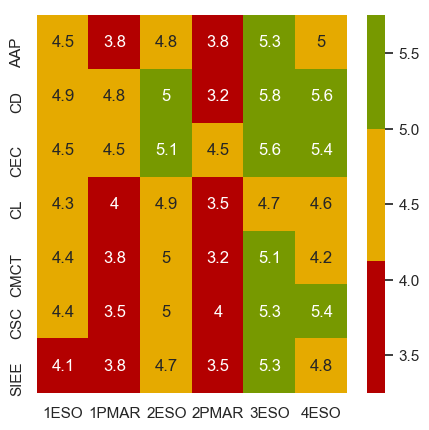

In [28]:
dfc_bc_marked = dfc_bc.groupby(['nivel', 'item']).mean().reset_index().pivot('item', 'nivel', 'marca')

sns.set_context('notebook')
charts.rgb_heatmap(dfc_bc_marked)

### Nivel competencial resumen por nivel

In [29]:
dfc_bc['marca'].groupby(dfc_bc['nivel']).mean().sort_values(ascending=False)

nivel
3ESO     5.291667
4ESO     4.989286
2ESO     4.922619
1ESO     4.440476
1PMAR    4.000000
2PMAR    3.678571
Name: marca, dtype: float64

### Nivel competencial resumen por competencias básicas

In [30]:
dfc_bc['marca'].groupby(dfc_bc['item']).mean().sort_values(ascending=False)

item
CD      5.094231
CEC     5.005769
CSC     4.790385
AAP     4.717308
SIEE    4.559615
CL      4.513462
CMCT    4.500000
Name: marca, dtype: float64

### Máximo nivel competencial

In [31]:
dfc_bc.iloc[dfc_bc.reset_index()['marca'].idxmax()][['item', 'marca']]

item        CD
marca    6.075
Name: ESO3B, dtype: object

### Mínimo nivel competencial

In [32]:
dfc_bc.iloc[dfc_bc.reset_index()['marca'].idxmin()][['item', 'marca']]

item     CMCT
marca    3.25
Name: ESO3D, dtype: object

## Evolución de los niveles competenciales

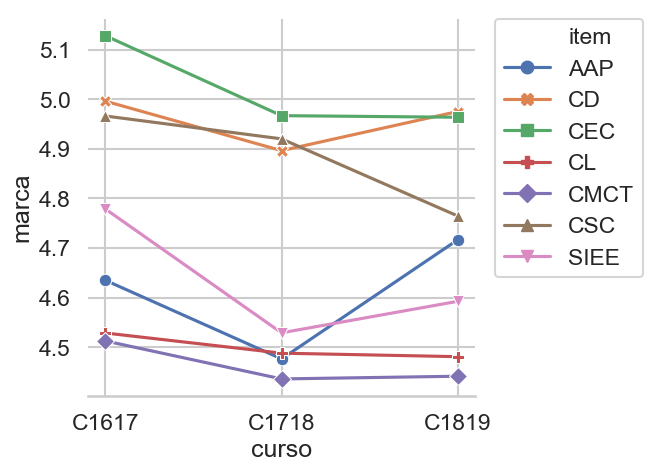

In [33]:
aux = df_bc.groupby(['curso', 'item']).mean().reset_index()[['curso', 'item', 'marca']]

sns.set_context('talk')
charts.bc_evolution_chart(aux)

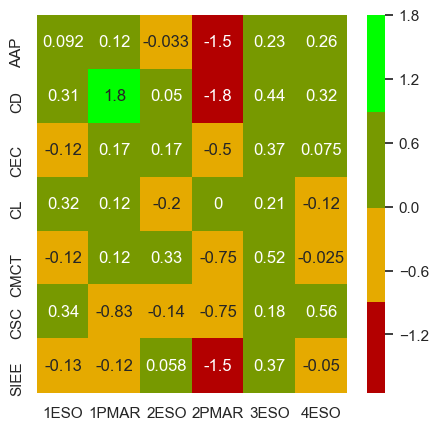

In [34]:
if EVALUATION > 1:
    display(HTML('<h2>Evolución competencial con respecto a la evaluación anterior'))

    df_bc_comp['delta'] = df_bc_comp['marca_x'] - df_bc_comp['marca_y']
    df_bc_comp_marked = df_bc_comp.groupby(['nivel_x', 'item']).mean().reset_index().pivot('item', 'nivel_x', 'delta')

    sns.set_context('notebook')
    charts.rgb_heatmap(df_bc_comp_marked, center=0)

# ABSENTISMO

<div class="alert alert-success" role="alert">
    ABSENTISMO = <b>Faltas justificadas + Faltas injustificadas</b>
</div>

**Se va a estudiar el ABSENTISMO ACUMULADO desde el 1 de septiembre hasta la fecha de finalización del trimestre de análisis.**

## ABSENTISMO TOTAL vs ABSENTISMO JUSTIFICADO

In [35]:
myplotly.hbar((dfc['absentismo'], dfc['absentismo_justificado']), dfc.index,
              trace_names=('Abs. Total (%)', 'Abs. Justificado (%)'))

## ESO

In [36]:
myplotly.bar_simple(dfc_ESO.index, dfc_ESO['absentismo'], colormap='Reds')

# FPB

In [37]:
myplotly.bar_simple(dfc_FPB.index, dfc_FPB['absentismo'], colormap='Reds')

## BACHILLERATO

In [38]:
myplotly.bar_simple(dfc_BACH.index, dfc_BACH['absentismo'], colormap='Reds')

## CICLOS FORMATIVOS DE GRADO MEDIO

In [39]:
myplotly.bar_simple(dfc_CFGM.index, dfc_CFGM['absentismo'], colormap='Reds')

## CICLOS FORMATIVOS DE GRADO SUPERIOR

In [40]:
myplotly.bar_simple(dfc_CFGS.index, dfc_CFGS['absentismo'], colormap='Reds')

## GLOBAL

In [41]:
myplotly.bar_simple(dfc_summary.index, dfc_summary['absentismo'], colormap='Reds')

## COMPARATIVA CON LOS ÚLTIMOS CURSOS

In [42]:
aux = df.groupby(['etapa', 'curso', 'evaluación']).mean().reset_index().set_index('etapa')
series = {year: aux.loc[stages].query(f'curso == "{year}" & evaluación == "{labels[-1][1]}"')['absentismo'].values
          for year in years}

myplotly.cbar(stages, series)

In [43]:
mean_absence = dfc['absentismo'].mean()
display(HTML(f'''
<div class='alert alert-info' role="alert">
    Absentismo global medio: <b>{mean_absence:.2f}</b>%
</div>
'''))

In [44]:
if EVALUATION > 1:
    display(HTML('<h2>EVOLUCIÓN DE GRUPOS CON RESPECTO A LA EVALUACIÓN ANTERIOR'))

    aux = df_comp['absentismo_x'] - df_comp['absentismo_y']
    myplotly.dbar(aux.index, aux, inverted_colors=True)

# GESTIÓN DE LA CONVIVENCIA

## PARTES DE GESTIÓN

In [45]:
dfc_reports = dfc.query('partes > 0')['partes']
myplotly.bar_simple(dfc_reports.index, dfc_reports, colormap='Reds', is_percentage=False)

## COMPARATIVA CON LOS ÚLTIMOS CURSOS

In [46]:
aux = df.groupby(['etapa', 'curso', 'evaluación']).sum().reset_index().set_index('etapa')
series = {year: aux.loc[stages].query(f'curso == "{year}" & evaluación == "{labels[-1][1]}"')['partes'].values
          for year in years}

myplotly.cbar(stages, series, is_percentage=False)

In [47]:
total_reports = dfc_reports.sum()
display(HTML(f'''
<div class='alert alert-info' role="alert">
    Total de partes de gestión: <b>{total_reports:.0f}</b>
</div>
'''))

In [48]:
if EVALUATION > 1:
    display(HTML('<h2>EVOLUCIÓN DE GRUPOS CON RESPECTO A LA EVALUACIÓN ANTERIOR'))

    aux = df_comp['partes_x'] - df_comp['partes_y']
    myplotly.dbar(aux.index, aux, is_percentage=False, inverted_colors=True)

## SUSPENSIÓN DEL DERECHO DE ASISTENCIA

In [49]:
dfc_non_attendance = dfc.query('suspensión_asistencia > 0')['suspensión_asistencia']
myplotly.bar_simple(dfc_non_attendance.index, dfc_non_attendance, colormap='Reds', is_percentage=False)

## COMPARATIVA CON LOS ÚLTIMOS CURSOS

In [50]:
aux = df.groupby(['etapa', 'curso', 'evaluación']).sum().reset_index().set_index('etapa')
series = {year: aux.loc[stages].query(f'curso == "{year}" & evaluación == "{labels[-1][1]}"')['suspensión_asistencia'].values
          for year in years}

myplotly.cbar(stages, series, is_percentage=False)

In [51]:
total_non_attendance = dfc_non_attendance.sum()
display(HTML(f'''
<div class='alert alert-info' role="alert">
    Total de partes de gestión con <b>suspensión</b> del derecho de asistencia: <b>{total_non_attendance:.0f}</b>
</div>
'''))

# RELACIÓN `éxito-competencias básicas`

> **NOTA**: Análisis únicamente con grupos de la ESO.

In [52]:
myplotly.scatter(dfc_ESO['éxito'], dfc_ESO['ccbb'], dfc_ESO.index,
        x_title='Éxito', y_title='Competencias básicas')

In [53]:
corr = dfc_ESO.corrwith(dfc['éxito'])['ccbb']
display(HTML(f'''
    <div class='alert alert-success' role='alert'>
        COEFICIENTE DE CORRELACIÓN: <b>{corr:.4f}</b>
    </div>
'''))

## Detección de *outliers*

### Bajo éxito y alta adquisición de competencias básicas

In [54]:
dfc_ESO[(dfc_ESO['éxito'] < 20) & (dfc_ESO['ccbb'] > 5)][['éxito', 'ccbb']]

,éxito,ccbb
grupo,,


### Alto éxito y baja adquisición de competencias básicas

In [55]:
dfc_ESO[(dfc_ESO['éxito'] > 50) & (dfc_ESO['ccbb'] < 4)][['éxito', 'ccbb']]

,éxito,ccbb
grupo,,


# RELACIÓN `ratio-éxito`

In [56]:
myplotly.scatter(dfc['ratio'], dfc['éxito'], dfc.index,
        x_title='Ratio', y_title='Éxito')

In [58]:
corr = dfc.corrwith(dfc['ratio'])['éxito']
display(HTML(f'''
    <div class='alert alert-success' role='alert'>
        COEFICIENTE DE CORRELACIÓN: <b>{corr:.4f}</b>
    </div>
'''))

## Detección de *outliers*

### Baja ratio y bajo éxito

In [59]:
dfc[(dfc['ratio'] < 20) & (dfc['éxito'] < 20)][['ratio', 'éxito']]

,ratio,éxito
grupo,,
ESO3D,10,10.0


### Alta ratio y alto éxito

In [60]:
dfc[(dfc['ratio'] > 25) & (dfc['éxito'] > 50)][['ratio', 'éxito']]

,ratio,éxito
grupo,,
ESO2A,28,53.6
1ALO,29,72.4
2GIT,28,82.1


# RELACIÓN `absentismo-éxito`

In [73]:
myplotly.scatter(dfc['absentismo'], dfc['éxito'], dfc.index,
        x_title='Absentismo', y_title='Éxito')

In [74]:
corr = dfc.corrwith(dfc['absentismo'])['éxito']
display(HTML(f'''
    <div class='alert alert-success' role='alert'>
        COEFICIENTE DE CORRELACIÓN: <b>{corr:.4f}</b>
    </div>
'''))

## Detección de *outliers*

### Bajo absentismo y bajo éxito

In [75]:
dfc[(dfc['absentismo'] < 10) & (dfc['éxito'] < 15)][['absentismo', 'éxito']]

,absentismo,éxito
grupo,,
ESO1C,7.78,12.0


### Alto absentismo y alto éxito

In [76]:
dfc[(dfc['absentismo'] > 25) & (dfc['éxito'] > 50)][['absentismo', 'éxito']]

,absentismo,éxito
grupo,,


# RELACIÓN `partes-éxito`

In [49]:
myplotly.scatter(dfc['partes'], dfc['éxito'], dfc.index,
        x_title='Partes de gestión', y_title='Éxito')

In [78]:
corr = dfc.corrwith(dfc['partes'])['éxito']
display(HTML(f'''
    <div class='alert alert-success' role='alert'>
        COEFICIENTE DE CORRELACIÓN: <b>{corr:.4f}</b>
    </div>
'''))

## Detección de *outliers*

### Bajo número de partes y bajo éxito

In [79]:
dfc[(dfc['partes'] < 10) & (dfc['éxito'] < 10)][['partes', 'éxito']]

,partes,éxito
grupo,,


### Alto número de partes y alto éxito

In [80]:
dfc[(dfc['partes'] > 15) & (dfc['éxito'] > 30)][['partes', 'éxito']]

,partes,éxito
grupo,,


# GRUPOS MÁGICOS

> Son aquellos que tienen mejores valores de éxito escolar, menor absentismo y menos partes de gestión.

\begin{equation}
magic = 0.6 · success + 0.2 · e^{-absence} + 0.2 · e^{-reports}
\end{equation}

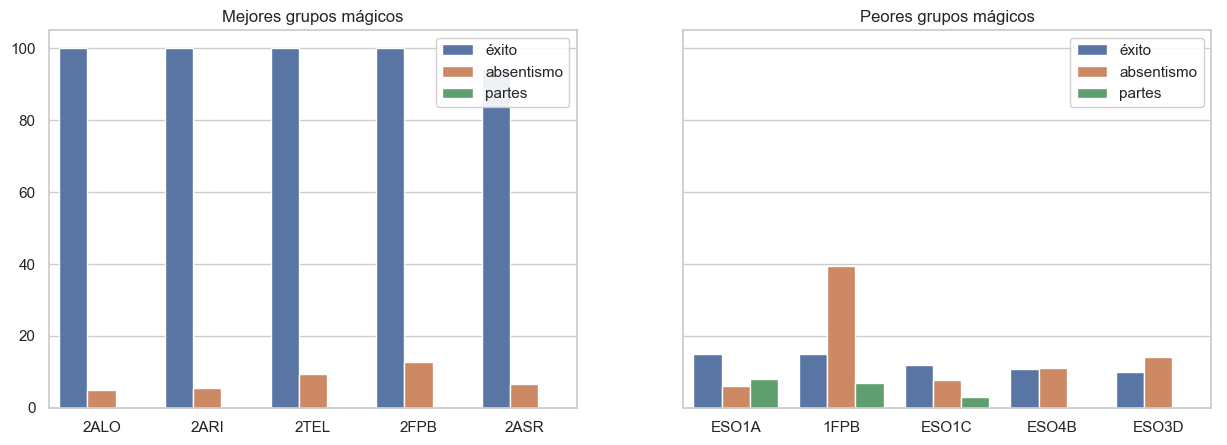

In [81]:
df2 = dfc.copy()
df2['magic'] = 0.6 * df2['éxito'] + 0.2 * \
    np.exp(-df2['absentismo']) + 0.2 * np.exp(-df2['partes'])
magic = df2.sort_values('magic', ascending=False)

charts.magic_groups(magic)

# PRUEBAS DE CERTIFICACIÓN PARA POBLACIÓN ESCOLAR

In [82]:
path = f'../data/pcei/{labels[-1][0]}_PCEI.csv'
df_pcei = pd.read_csv(path, encoding='cp1252', sep=';', nrows=2, usecols=range(5, 8), engine='python')

df_pcei.rename(columns={'GRUPO': 'grupo', 'NEGATIVAS': 'NO CERTIFICA', 'POSITIVAS': 'CERTIFICA'}, inplace=True)
df_pcei

,grupo,NO CERTIFICA,CERTIFICA
0,ING-B1,16,18
1,ING-B2,11,16


In [91]:
x_labels = df_pcei['grupo']
series = df_pcei.drop('grupo', axis=1).to_dict(orient='list')

myplotly.cbar(x_labels, series, is_percentage=False)